In [1]:
from ceo import constants, StopWatch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/ubuntu/CEO/python/ceo/zemax


# WFPT model demo with a SH48
This demo shows how to use the Wide Field Phasing Testbed (WFPT) model developed in CEO, using a single on-axis SH48 WFS.

Developed by: F. Quiros-Pacheco (GMTO)

Last update: 25/02/2022

## Initialize WFPT model
The WFPT package is located in **~/CEO/python/ceo/wfpt/** . There are so far three WFPT classes:
1. **wfpt_testbed**. The main WFPT testbed class that enables ray tracing through the WFPT Zemax model imported in CEO.
2. **wfpt_source**. The class that emulates the illumination source. It contains a "rays bundle" object to raytrace through the WFPT model, and a "CEO Source" object to enable WF propagation from the exit pupil of the WFPT testbed to the WFS. Currently only on-axis propagation possible.
3. **wfpt_sh48**. A wrapper class for the "CEO ShackHartmann" class that implements the SH48 model.

In [2]:
from ceo import wfpt_testbed, wfpt_source, wfpt_sh48

In [3]:
#----------------- WFPT model -----------------------------------
M2_baffle_diam=3.6  # size of M2 baffle
project_truss_onaxis=True # simulate truss shadows over central segment

wfpt = wfpt_testbed(M2_baffle_diam=M2_baffle_diam, project_truss_onaxis=project_truss_onaxis)

In [4]:
#----------------- SH Source model ------------------------------
sh_band = 'R+I'
sh_mag = 10
sh_L = 27.31 # m
sh_nPx = 801 # pixels across L
src = wfpt_source(sh_band, sh_nPx, sh_L, mag=sh_mag)

In [5]:
#----------------- SH model -------------------------------------
wfs = wfpt_sh48(sh_nPx)

## Propagate a flat wavefront and do calibrations
Activate the keyword **keep_rays_for_plot** if you want to show a ray diagram. Otherwise, set it to *False* to speed up the ray tracing.

In [6]:
keep_rays_for_plot = True

In [7]:
%%time
src.reset()
wfpt.reset()
wfpt.propagate(src, keep_rays_for_plot=keep_rays_for_plot)
opd0 = src._gs.phase.host()

CPU times: user 1.28 s, sys: 792 ms, total: 2.07 s
Wall time: 2.06 s


### Show the WF at the exit pupil

on-axis WFE: 305.8 nm RMS


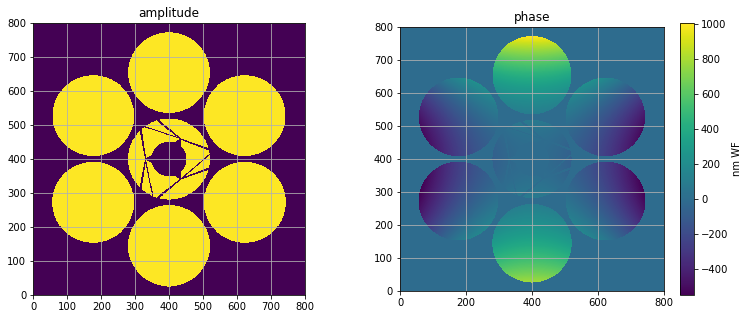

In [9]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
ax1.imshow(src._gs.amplitude.host(), origin='lower',interpolation='None')
ax1.set_aspect('equal')
ax1.grid()
im2 = ax2.imshow(opd0*1e9, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2, label='nm WF')
ax1.set_title('amplitude')
ax2.set_aspect('equal')
ax2.grid()
ax2.set_title('phase')

print("on-axis WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))

### Show the rays diagram

In [10]:
if keep_rays_for_plot:
    xyz,klm,sid = wfpt.rays_data
    vig = src.rays.vignetting.host().ravel()>0

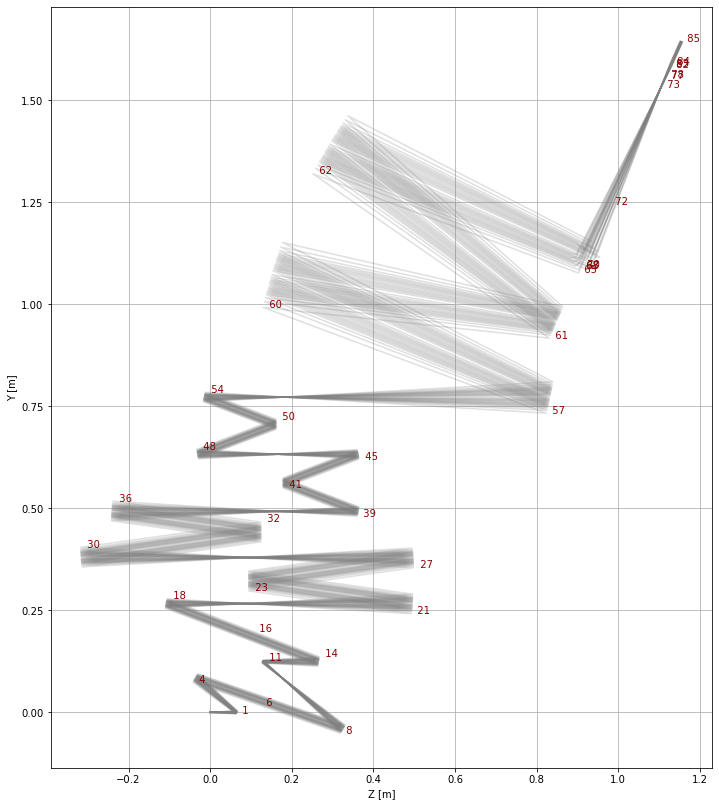

In [11]:
if keep_rays_for_plot:
    fig,ax = plt.subplots(figsize=(16,14))
    #plt.style.use('dark_background')
    for k in range(1,vig.sum(),10000):
        ray = np.vstack([w[vig,:][k] for w in xyz[:len(sid)+1]])
        ax.plot(ray[:,2],ray[:,1],'gray',alpha=0.25)    
    chief_ray = np.vstack([w[vig,:][0] for w in xyz[:len(sid)+1]])
    htz = [ax.text(chief_ray[k+1,2],chief_ray[k+1,1],f"  {sid[k]}",fontdict={'color':'darkred'}) for k in range(len(sid))]
    #chief_ray = np.vstack([w[vig,:][-1] for w in xyz[:len(sid)+1]])
    #htc = [ax.text(chief_ray[k+1,2],chief_ray[k+1,1],f"  {k+1}") for k in range(len(sid))]
    ax.grid()
    ax.set_aspect('equal')
    ax.set_xlabel('Z [m]')
    ax.set_ylabel('Y [m]');

### Calibrate SH48
The calibration of the SH48 needs to be done with an extended source. Set the parameter **src.fwhm** to define an extended source.

Source FWHM: 0.810 arcsec


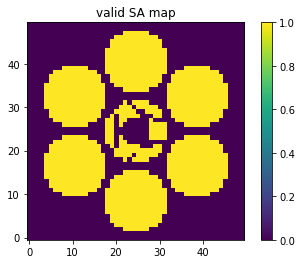

In [12]:
src.fwhm = 6
wfs.calibrate(src, 0.75)

plt.imshow(wfs.valid_lenslet.f.host().reshape((wfs.N_SIDE_LENSLET,wfs.N_SIDE_LENSLET)),
          origin='lower', interpolation='None')
plt.colorbar();
plt.title('valid SA map');

In [13]:
vsubIdx = wfs.valid_lenslet.f.host().reshape((wfs.N_SIDE_LENSLET,wfs.N_SIDE_LENSLET)).astype('bool')
print("Total valid sub-apertures: %d"%(wfs.get_measurement_size()//2))

Total valid sub-apertures: 1082


#### Evaluating reference centroids

As fininte differences (expected reference slopes):

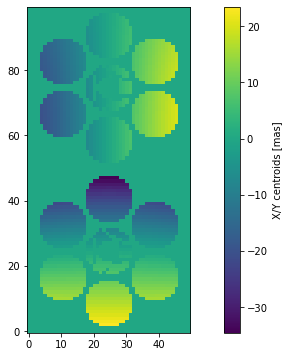

In [14]:
cxy = src._gs.wavefront.finiteDifference(wfs.N_SIDE_LENSLET, src._gs.rays.L / wfs.N_SIDE_LENSLET, wfs.valid_lenslet)

plt.figure(figsize=(12,6))
plt.imshow(cxy.host(units='mas'), origin='lower', interpolation='None')
plt.colorbar(label="X/Y centroids [mas]")
#4*1400e-9/L*ceo.constants.RAD2MAS

The actual reference slopes:

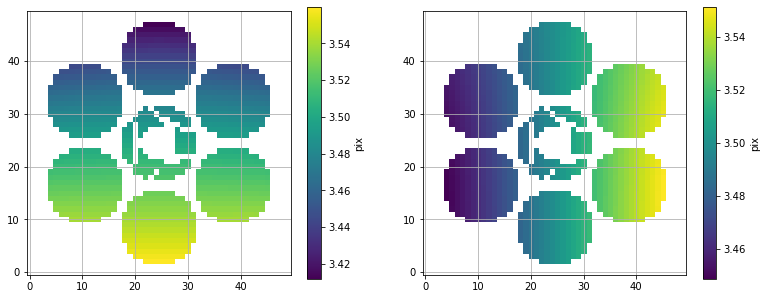

In [15]:
sh_ref = np.squeeze(wfs.valid_reference_slopes.host())
sxref2d = np.full((wfs.N_SIDE_LENSLET,wfs.N_SIDE_LENSLET), np.nan)
sxref2d[vsubIdx] = sh_ref[0:wfs.get_measurement_size()//2]
syref2d = np.full((wfs.N_SIDE_LENSLET,wfs.N_SIDE_LENSLET), np.nan)
syref2d[vsubIdx] = sh_ref[wfs.get_measurement_size()//2:]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
im1 = ax1.imshow(sxref2d, origin='lower',interpolation='None')
h1 = plt.colorbar(im1, ax=ax1, label='pix')
ax1.set_aspect('equal')
ax1.grid()
im2 = ax2.imshow(syref2d, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2, label='pix')
ax2.set_aspect('equal')
ax2.grid()

## Apply commands to Active Mirrors and propagate wavefront
A state vector is defined containing the following degrees of freedom:
1. **M1_PTT**: 
    1. *segment piston*    (7)
    2. *segment tip-tilt*  (7x2)
2. **M2_PTT:** idem
3. **M1_DM:** 
    1. *actuators*      (292)
4. **M2_DM:** idem

In [16]:
print(wfpt.state)

{'M1_PTT': {'segment piston': array([0., 0., 0., 0., 0., 0., 0.]), 'segment tip-tilt': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])}, 'M2_PTT': {'segment piston': array([0., 0., 0., 0., 0., 0., 0.]), 'segment tip-tilt': array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])}, 'M1_DM': {'actuators': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 

To apply a command you should:
1. Extract a copy of the state vector (can be done only once);
2. Modify the copy of the state vector as desired;
3. Update the WFPT model with the desired state vector.

In [17]:
wfpt.reset()

# Extract copy of state vector
state = wfpt.state

# Modify the state vector as desired
state['M2_DM']['actuators'][50] = 1
state['M2_PTT']['segment tip-tilt'][2,0] = 1e-4

# Update the WFPT model with the desired state vector
wfpt.update(state)

Propagate WF

In [18]:
%%time
src.reset()
wfpt.propagate(src)
opd = src._gs.phase.host()

CPU times: user 744 ms, sys: 348 ms, total: 1.09 s
Wall time: 1.09 s


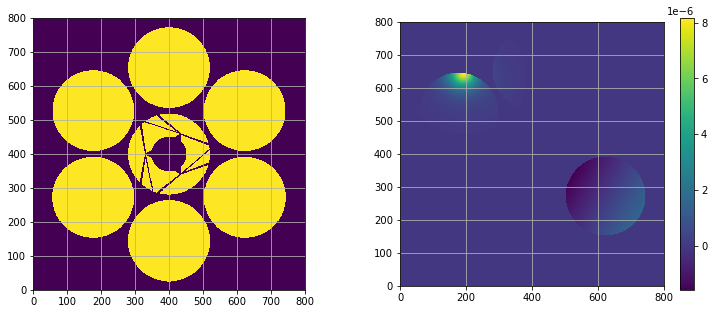

In [19]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
ax1.imshow(src._gs.amplitude.host(), origin='lower',interpolation='None')
ax1.set_aspect('equal')
ax1.grid()
im2 = ax2.imshow(opd-opd0, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2)
ax2.set_aspect('equal')
ax2.grid()

### SH measurements

Text(0.5, 1.0, 'X and Y SH48 centroids')

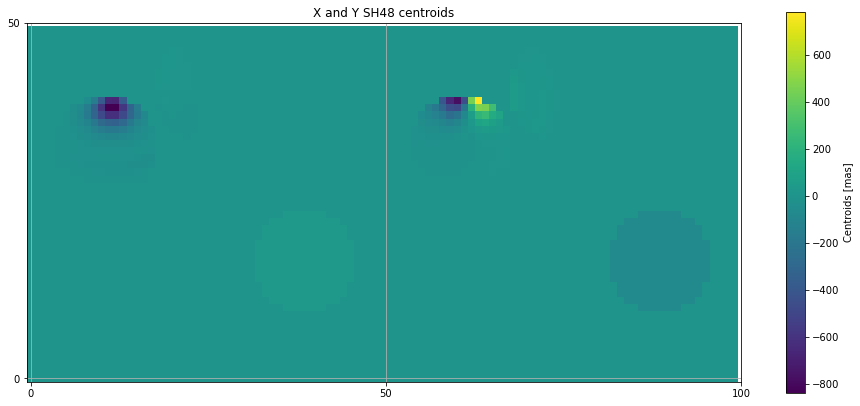

In [20]:
wfs.reset()
wfs.propagate(src)
wfs.process()

fig ,ax = plt.subplots()
fig.set_size_inches(16,7)
s = wfs.c.host()
h = ax.imshow(constants.RAD2MAS*np.hstack(np.hsplit(np.hstack(np.vsplit(
    s.reshape(wfs.N_GS*wfs.N_SIDE_LENSLET*2,wfs.N_SIDE_LENSLET),2)),2)),origin='lower', interpolation='None')
plt.colorbar(h,ax=ax,label='Centroids [mas]')
ax.set_yticks(range(0,wfs.N_SIDE_LENSLET*(wfs.N_GS+1),wfs.N_SIDE_LENSLET))
ax.set_xticks(range(0,wfs.N_SIDE_LENSLET*3,wfs.N_SIDE_LENSLET))
ax.grid()
ax.set_title("X and Y SH48 centroids")

WFS detector frame:

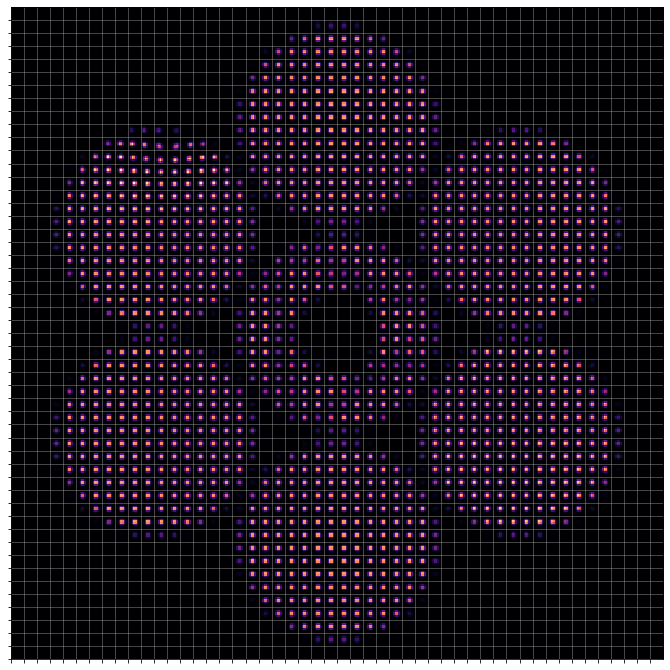

In [21]:
fig,ax = plt.subplots(figsize=(16,12))
ax.imshow(wfs.camera.frame.host(),cmap='magma', origin='lower', interpolation='None')
ax.set_xticks(np.arange(0,8*wfs.N_SIDE_LENSLET,8)-0.5)
ax.set_yticks(np.arange(0,8*wfs.N_SIDE_LENSLET,8)-0.5)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(alpha=0.5)

# Interaction Matrix Calibration

## M1 ALPAO zonal IFs - SH WFS

In [22]:
%%time
D_M1_ALPAO = wfpt.calibrate(wfs, src, mirror='M1', mode='actuators', stroke=0.1)

___ M1 ___ (actuators)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271

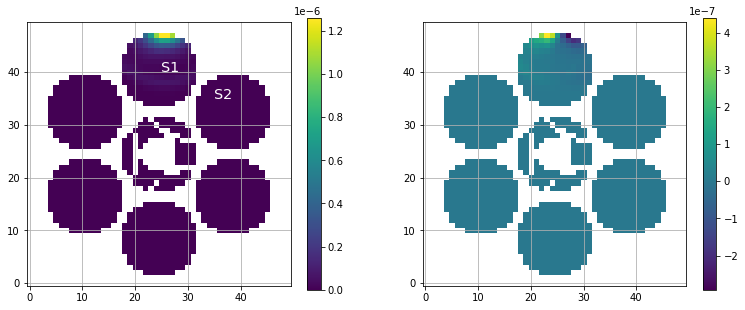

In [23]:
this_act = 1

sx2d = np.full((wfs.N_SIDE_LENSLET,wfs.N_SIDE_LENSLET), np.nan)
sx2d[vsubIdx] = D_M1_ALPAO[0:wfs.get_measurement_size()//2,this_act]
sy2d = np.full((wfs.N_SIDE_LENSLET,wfs.N_SIDE_LENSLET), np.nan)
sy2d[vsubIdx] = D_M1_ALPAO[wfs.get_measurement_size()//2:,this_act]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
im1 = ax1.imshow(sx2d, origin='lower',interpolation='None')
h1 = plt.colorbar(im1, ax=ax1)
ax1.set_aspect('equal')
ax1.grid()
im2 = ax2.imshow(sy2d, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2)
ax2.set_aspect('equal')
ax2.grid()

ax1.text(25,40,'S1',fontsize='x-large', color='white');
ax1.text(35,35,'S2',fontsize='x-large', color='white');


## Reconstruction Matrix
Inverse of M1_DM-SH matrix

M1 DM - SH48 IM:
(2164, 292)
conditioning number:
551.8246577031282


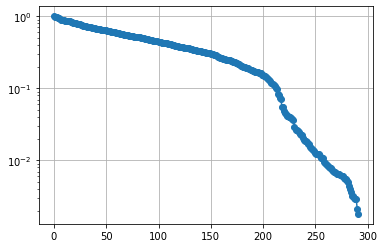

In [24]:
print('M1 DM - SH48 IM:')
print(D_M1_ALPAO.shape)
print("conditioning number:")
print(np.linalg.cond(D_M1_ALPAO))

UU1, ss1, VVT1 = np.linalg.svd(D_M1_ALPAO, full_matrices=False)
plt.semilogy(ss1/np.max(ss1), 'o-')
plt.grid()

In [25]:
R_M1_ALPAO = np.linalg.pinv(D_M1_ALPAO)

### Test reconstructor

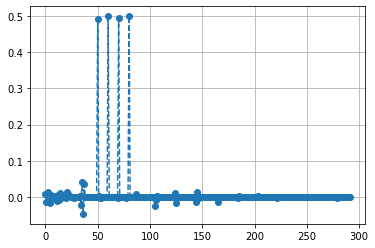

In [26]:
wfpt.reset()
state = wfpt.state
state['M1_DM']['actuators'][80] = 0.5
state['M1_DM']['actuators'][70] = 0.5
state['M1_DM']['actuators'][60] = 0.5
state['M1_DM']['actuators'][50] = 0.5

wfpt.update(state)

src.reset()
wfpt.propagate(src)
WFin = src._gs.phase.host()

wfs.reset()
wfs.propagate(src)
wfs.process()
sh_meas = wfs.get_measurement()

dm1_comm = R_M1_ALPAO @ sh_meas

#plt.imshow(WFin-opd0, origin='lower', interpolation='None')
#plt.colorbar()
plt.plot(dm1_comm, 'o--')
plt.grid()

## M1 PTT array: Segment TT - SH WFS

In [27]:
%%time
D_M1_PTTarray_TT = wfpt.calibrate(wfs, src, mirror='M1', mode='segment tip-tilt', stroke=1e-4)

___ M1 ___ (segment tip-tilt)
Segment #:1 2 3 4 5 6 7 
------------
CPU times: user 20.2 s, sys: 10.6 s, total: 30.8 s
Wall time: 30.8 s


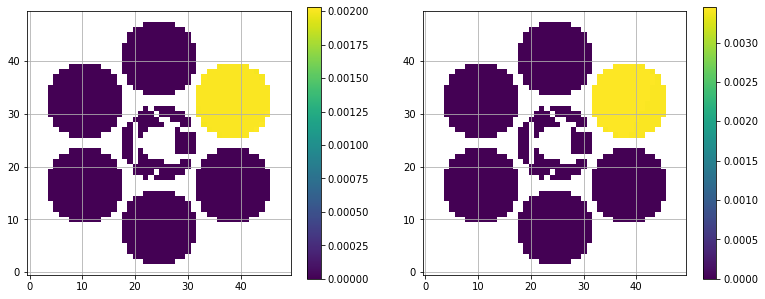

In [29]:
this_mode = 2

sx2d = np.full((wfs.N_SIDE_LENSLET,wfs.N_SIDE_LENSLET), np.nan)
sx2d[vsubIdx] = D_M1_PTTarray_TT[0:wfs.get_measurement_size()//2,this_mode]
sy2d = np.full((wfs.N_SIDE_LENSLET,wfs.N_SIDE_LENSLET), np.nan)
sy2d[vsubIdx] = D_M1_PTTarray_TT[wfs.get_measurement_size()//2:,this_mode]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches((13,5))
im1 = ax1.imshow(sx2d, origin='lower',interpolation='None')
h1 = plt.colorbar(im1, ax=ax1)
ax1.set_aspect('equal')
ax1.grid()
im2 = ax2.imshow(sy2d, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2)
ax2.set_aspect('equal')
ax2.grid()

# Perform a closed-loop test
Introduce an initial scramble of segment TT, and close the loop with the DM.

## Introduce a scramble

In [30]:
from numpy.random import default_rng
rng = default_rng(seed=1454)

WFE: 482.8 nm RMS


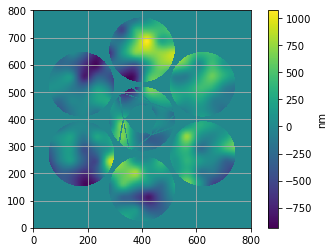

In [31]:
# Scramble:
wfpt.reset()
state0 = wfpt.state
#state0['M1_PTT']['segment tip-tilt'][:] = rng.standard_normal(size=(7,2)) * 1e-4
#state0['M1_PTT']['segment tip-tilt'][0,0] = 1e-4
#state0['M1_DM']['actuators'][181] = 0.5
state0['M1_DM']['actuators'][:] = rng.standard_normal(size=wfpt.M1_DM.modes.n_mode)*0.05
wfpt.update(state0)

# Visualize the scramble
src.reset()
wfpt.propagate(src)
opd = src._gs.phase.host()
print("WFE: %0.1f nm RMS"%(src._gs.phaseRms()*1e9))
fig, ax2 = plt.subplots()
im2 = ax2.imshow((opd-opd0)*1e9, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2, label='nm')
ax2.set_aspect('equal')
ax2.grid()

## Close the loop

In [32]:
import sys

In [33]:
totSimulIter = 30
gain = 0.2
tid = StopWatch()

M1_DM_comm_buffer = np.zeros(wfpt.M1_DM.modes.n_mode)
wfe_iter = np.zeros(totSimulIter)

In [34]:
# Get 
wfpt.reset()
state = wfpt.state

# Load initial scramble
wfpt.update(state0)

for jj in range(totSimulIter):
    tid.tic()
    src.reset()
    wfpt.propagate(src)
    wfe_iter[jj] = src._gs.wavefront.rms()
    
    #--- WFS measurements and command
    wfs.reset()
    wfs.propagate(src)
    wfs.process()
    measvec = wfs.get_measurement()
    M1_DM_delta_comm = R_M1_ALPAO @ measvec
    M1_DM_comm_buffer += gain * M1_DM_delta_comm
    
    #--- Update state vector
    state['M1_DM']['actuators'] = -M1_DM_comm_buffer
    wfpt.update(state0+state)

    tid.toc()
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_iter[jj]*1e9))
    sys.stdout.flush()   


 iter: 29/30, ET: 1101.77, WFE [nm WF RMS] on-axis: 305.8

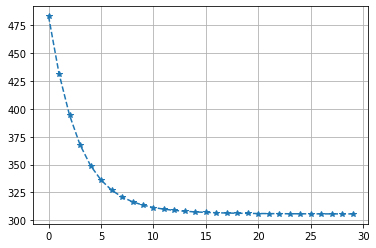

In [35]:
plt.plot(wfe_iter*1e9, '*--')
plt.grid()

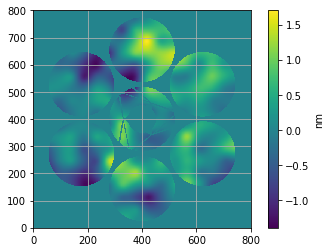

In [36]:
opd = src._gs.phase.host()

fig, ax2 = plt.subplots()
im2 = ax2.imshow((opd-opd0)*1e9, origin='lower', interpolation='None')
h2 = plt.colorbar(im2, ax=ax2, label='nm')
ax2.set_aspect('equal')
ax2.grid()

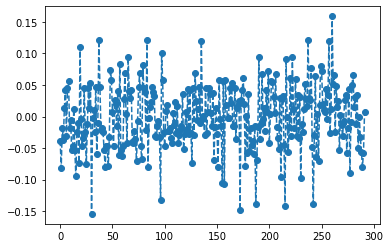

In [37]:
plt.plot(M1_DM_comm_buffer, 'o--')